In [38]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from PIL import Image
import shutil



In [39]:
# ========================
# CONFIGURATION
# ========================
IMG_SIZE = (224, 224)  # EfficientNet default size
BATCH_SIZE = 32
EPOCHS = 15
INIT_LR = 1e-4
SEED = 42

In [40]:
# Set paths (UPDATE THESE TO YOUR DATASET PATHS)
BASE_DIR = r"C:\Project 5"
train_dir = os.path.join(BASE_DIR, r'C:\Project 5\Train')  # Should contain 'real' and 'ai_gen' subfolders
test_dir = os.path.join(BASE_DIR, r'C:\Project 5\Test')    # Same structure as train

In [41]:
# Define processed directories
train_processed_dir = os.path.join(BASE_DIR, r'Train_processed')
test_processed_dir = os.path.join(BASE_DIR, r'Test_processed')

In [42]:
# ========================
# PREPROCESSING FUNCTION
# ========================
def resize_large_images(input_dir, output_dir, max_pixels=178956970, target_size=(224, 224)):
    """
    Resizes images exceeding the specified pixel limit and saves them to the output directory.
    Images within the limit are copied as is.
    
    Parameters:
    - input_dir: str, path to the input directory containing images.
    - output_dir: str, path to the output directory for processed images.
    - max_pixels: int, maximum allowed pixels before resizing (default is PIL's limit).
    - target_size: tuple, target size for resizing (default is (224, 224)).
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    width, height = img.size
                    rel_path = os.path.relpath(root, input_dir)
                    out_subdir = os.path.join(output_dir, rel_path)
                    if not os.path.exists(out_subdir):
                        os.makedirs(out_subdir)
                    out_path = os.path.join(out_subdir, file)
                    
                    if width * height > max_pixels:
                        print(f"Resizing {img_path} from {width}x{height} to {target_size}")
                        img = img.resize(target_size, Image.LANCZOS)
                        img.save(out_path)
                    else:
                        shutil.copy(img_path, out_path)

In [17]:
# Preprocess the training and test datasets
resize_large_images(train_dir, train_processed_dir)
resize_large_images(test_dir, test_processed_dir)

In [43]:
# Update train_dir and test_dir to point to processed directories
train_dir = train_processed_dir
test_dir = test_processed_dir

In [44]:
# ========================
# DATA PREPARATION
# ========================
# Data augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode='nearest'
)

# Validation/test generators (no augmentation)
valtest_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    seed=SEED
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    seed=SEED
)

test_generator = valtest_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 17163 images belonging to 2 classes.
Found 4290 images belonging to 2 classes.
Found 1944 images belonging to 2 classes.


In [45]:
# ========================
# MODEL ARCHITECTURE
# ========================
def create_model():
    # Load pre-trained EfficientNet without top layers
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
        pooling=None
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Create new model on top
    inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = base_model(inputs, training=False)
    
    # Add custom head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs, outputs)
    
    optimizer = optimizers.Adam(learning_rate=INIT_LR)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

model = create_model()

In [46]:
# ========================
# CALLBACKS
# ========================
callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    callbacks.ModelCheckpoint(
        'best_model.keras',  # Save as .keras
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7
    ),
    callbacks.TensorBoard(log_dir='./logs')
]

In [47]:
# ========================
# TRAINING
# ========================
print("\n=== Initial Training ===")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks
)

# Fine-tuning (unfreeze top layers)
def unfreeze_model(model):
    # Unfreeze the top 50 layers while keeping BatchNorm layers frozen
    for layer in model.layers[-50:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    
    optimizer = optimizers.Adam(learning_rate=INIT_LR/10)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )




=== Initial Training ===


c:\Users\Priyanshu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
  8/537 ━━━━━━━━━━━━━━━━━━━━ 6:56 787ms/step - accuracy: 0.5124 - auc: 0.4688 - loss: 1.1137

c:\Users\Priyanshu\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


537/537 ━━━━━━━━━━━━━━━━━━━━ 572s 1s/step - accuracy: 0.7867 - auc: 0.8588 - loss: 0.5074 - val_accuracy: 0.9035 - val_auc: 0.9725 - val_loss: 0.2533 - learning_rate: 1.0000e-04
Epoch 2/15
537/537 ━━━━━━━━━━━━━━━━━━━━ 543s 1s/step - accuracy: 0.8874 - auc: 0.9515 - loss: 0.2873 - val_accuracy: 0.9002 - val_auc: 0.9679 - val_loss: 0.2526 - learning_rate: 1.0000e-04
Epoch 3/15
537/537 ━━━━━━━━━━━━━━━━━━━━ 543s 1s/step - accuracy: 0.8974 - auc: 0.9582 - loss: 0.2661 - val_accuracy: 0.9207 - val_auc: 0.9778 - val_loss: 0.2108 - learning_rate: 1.0000e-04
Epoch 4/15
537/537 ━━━━━━━━━━━━━━━━━━━━ 543s 1s/step - accuracy: 0.9070 - auc: 0.9645 - loss: 0.2404 - val_accuracy: 0.9287 - val_auc: 0.9809 - val_loss: 0.1950 - learning_rate: 1.0000e-04
Epoch 5/15
537/537 ━━━━━━━━━━━━━━━━━━━━ 543s 1s/step - accuracy: 0.9129 - auc: 0.9691 - loss: 0.2235 - val_accuracy: 0.9238 - val_auc: 0.9824 - val_loss: 0.1958 - learning_rate: 1.0000e-04
Epoch 6/15
537/537 ━━━━━━━━━━━━━━━━━━━━ 548s 1s/step - accuracy: 0


=== Evaluation ===
61/61 ━━━━━━━━━━━━━━━━━━━━ 38s 579ms/step - accuracy: 0.9710 - auc: 0.5113 - loss: 0.0866

Test Accuracy: 91.72%
Test AUC: 97.95%
61/61 ━━━━━━━━━━━━━━━━━━━━ 37s 587ms/step

Classification Report:
              precision    recall  f1-score   support

          AI       0.87      0.97      0.92       960
        Real       0.97      0.86      0.91       984

    accuracy                           0.92      1944
   macro avg       0.92      0.92      0.92      1944
weighted avg       0.92      0.92      0.92      1944



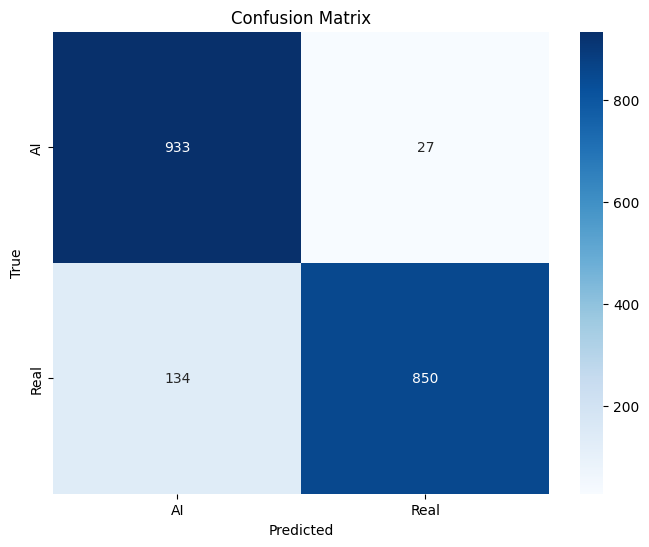

In [48]:
# ========================
# EVALUATION
# ========================
print("\n=== Evaluation ===")
best_model = models.load_model('best_model.keras')  # Load .keras model

# Test set evaluation
test_results = best_model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_results[1]*100:.2f}%")
print(f"Test AUC: {test_results[2]*100:.2f}%")

# Predictions
y_pred = (best_model.predict(test_generator) > 0.5).astype(int)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

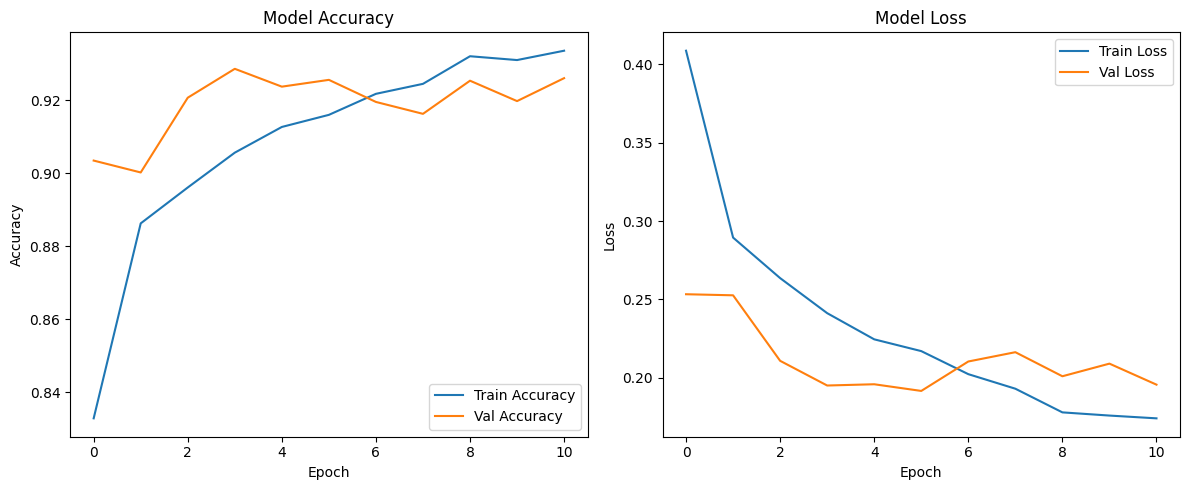

In [49]:
# ========================
# VISUALIZATION
# ========================
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

Model loaded successfully
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


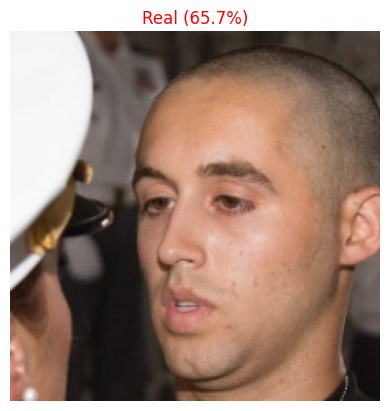

In [2]:
# prediction_script.py
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

# Load the saved model
best_model = tf.keras.models.load_model('best_model.keras')
print("Model loaded successfully")

# Prediction function (same as yours)
def predict_image(model, image_path):
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return
    
    try:
        img = tf.keras.utils.load_img(image_path, target_size=(224, 224))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        
    
        prediction = model.predict(img_array)
        probability = prediction[0][0]
        
        plt.imshow(img)
        plt.axis('off')
        
        if probability > 0.5:
            plt.title(f"Real ({probability*100:.1f}%)", color='red')
        else:
            plt.title(f"AI-Generated ({(1-probability)*100:.1f}%)", color='green')
        plt.show()
    except Exception as e:
        print(f"Error processing image: {e}")

# Example usage
if __name__ == "__main__":
    predict_image(best_model, r"C:\Project 3\Train\Real\392.jpg")  # Adjust path